# CelebA Dataset

* site : http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

# DCGAN

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.preprocessing import LabelBinarizer

## Download & Load CelebA

In [2]:
import os
import sys
import urllib
import zipfile

In [3]:
SavePath = 'CelebA_data/'

##### Download

In [4]:
if not os.path.exists(SavePath):
    # Dropbox Link can be terminated
    link = 'https://www.dropbox.com/s/gxjc9p7s6xmo09k/CelebA_Align.zip?dl=1'
    url = urllib.request.urlopen(link)

    filesize = int(url.headers['Content-Length'])
    filename = 'CelebA_Align.zip'

    with open(filename, 'wb') as f:
        downloaded = 0
        block_size = 8192
        status_width = 70
        while True:
            buffer = url.read(block_size)
            if not buffer:
                break

            downloaded += len(buffer)
            f.write(buffer)
            status = (("[%-" + str(status_width + 1) + "s] %3.2f%%") %
              ('=' * int(downloaded / filesize * status_width) + '>', downloaded * 100 / filesize))
            display.clear_output(wait=True)
            print(status, end='')

    with zipfile.ZipFile(filename) as zf:
        print('\nExtracting %s ...' % filename)
        zf.extractall(SavePath)
        print('Done.')

    os.remove(filename)

##### Load

In [5]:
file_names = []
file_tags = []
with open(SavePath + 'list_attr_celeba.txt') as f:
    data_size = int(f.readline())
    tag_list = np.array(f.readline().split())
    
    for line in f.readlines():
        file_name, *tagging = line.split()
        file_names.append(file_name)
        file_tags.append((np.array(tagging).astype(int) == 1).astype(int))
        
    file_names = np.array(file_names)
    file_tags = np.array(file_tags)
    
file_size = len(file_names)

In [6]:
def image_load(name, width, height):
    img = Image.open(SavePath + 'img_align_celeba/' + name)
    img = img.resize((width, height), resample=Image.ANTIALIAS)
    pixel = np.array([x for x in img.getdata()])
    return pixel.reshape(width, height, 3)

In [7]:
loaded_set = {}
def batch_from_dataset(names, width, height):
    batch = []
    for name in names:
        if name not in loaded_set:
            loaded_set[name] = image_load(name, width, height)
        batch.append(loaded_set[name])
        
    return np.array(batch) / 255

## Function Implement

In [8]:
# Reference : https://github.com/GunhoChoi/LSGAN_TF/blob/master/LSGAN/LSGAN_TF.ipynb
def LeakyReLU(x, leak=0.2, name='LeakyReLU'):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [9]:
def LinearUnit(x, name='Linear'):
    with tf.variable_scope(name):
        return x

In [10]:
def fully_connected_layer(x, output_size, initializer=tf.truncated_normal_initializer(stddev=2e-2), activation=tf.nn.relu, batch_normalization=None, name=''):
    w = tf.get_variable(name + '_weight', [x.get_shape()[1], output_size], initializer=initializer)
    b = tf.get_variable(name + '_bias', [output_size], initializer=initializer, dtype=tf.float32)
    
    l = tf.nn.bias_add(tf.matmul(x, w), b, name=name + '_layer')
    
    if batch_normalization != None:
        l = tf.layers.batch_normalization(l, **batch_normalization, name=name + '_batch_norm')
    
    return activation(l, name=name + '_' + activation.__name__), l, w, b

In [11]:
def conv_2d(x, kernel_size, stride_size=[1, 1, 1, 1], padding='SAME', initializer=tf.truncated_normal_initializer(stddev=2e-2), activation=tf.nn.relu, batch_normalization=None, name=''):
    if type(kernel_size) == tuple: kernel_size = list(kernel_size)
    if kernel_size[2] == -1: kernel_size[2] = int(x.get_shape()[-1])

    w = tf.get_variable(name + '_weight', kernel_size, initializer=initializer)
    b = tf.get_variable(name + '_bias', kernel_size[-1], initializer=initializer)
    c = tf.nn.conv2d(x, w, strides=stride_size, padding=padding)
    
    l = tf.nn.bias_add(c, b, name=name + '_layer')
    
    if batch_normalization != None:
        l = tf.layers.batch_normalization(l, **batch_normalization, name=name + '_batch_norm')
    
    return activation(l, name=name + '_' + activation.__name__), l, w, b

In [12]:
def deconv_2d(x, kernel_size, output_shape, stride_size=[1, 1, 1, 1], padding='SAME', initializer=tf.random_normal_initializer(stddev=2e-2), activation=tf.nn.relu, batch_normalization=None, name=''):
    if type(kernel_size) == tuple: kernel_size = list(kernel_size)
    if kernel_size[2] == -1: kernel_size[2] = output_shape[-1]
    if kernel_size[3] == -1: kernel_size[3] = int(x.get_shape()[-1])
    
    if type(output_shape) == tuple: output_shape = list(output_shape)
    if output_shape[0] == -1: output_shape[0] = tf.shape(x)[0]
    
    w = tf.get_variable(name + '_weight', kernel_size, initializer=initializer)
    b = tf.get_variable(name + '_bias', kernel_size[-2], initializer=initializer)
    c = tf.nn.conv2d_transpose(x, w, output_shape=output_shape, strides=stride_size, padding=padding)
    
    l = tf.nn.bias_add(c, b, name=name + '_layer')
    
    if batch_normalization != None:
        l = tf.layers.batch_normalization(l, **batch_normalization, name=name + '_batch_norm')
    
    return activation(l, name=name + '_' + activation.__name__), l, w, b

In [13]:
def _batch_norm(x, params, name=''):
    return tf.layers.batch_normalization(x, **params, name=name)

In [14]:
def _activation(x, activation, name=''):
    return activation(x, name=name)

### Model Maker Class

In [15]:
class ModelMaker(object):
    def __init__(self, layers_shape):
        self.layers_shape = layers_shape
        
    def __call__(self, x, name, dropout_list=None, reuse=False):
        parameters = set()
        layers = set()
        
        last_layer = x
        
        dropout = None
                
        # scope set
        with tf.variable_scope(name, reuse=reuse) as scope:
            # create layers
            for i, (layer_type, *layer_shape) in enumerate(self.layers_shape):
                
                '''
                create matching layer
                
                c2l  : Convolutional 2 Dimention Layer
                dc2l : Deconvolutional 2 Dimention Layer
                fcl  : Fully Connected Layer(Dense) Layer
                mpl  : Max Pooling Layer
                rs   : Reshape
                flat : Flatten
                bn   : Batch Normalization
                activation : Activation
                '''
                if layer_type == 'c2l': # Convolutional 2D Layer
                    kernel_shape, stride_shape, dropout, params = layer_shape
                    
                    last_layer, l, w, b = conv_2d(x=last_layer, \
                                            kernel_size=kernel_shape, stride_size=stride_shape, \
                                            name=str(i) + '_c2', **params)
                    
                    parameters.add(w)
                    parameters.add(b)
                    layers.add(last_layer)
                    layers.add(l)
                    
                elif layer_type == 'dc2l': # Deconvolutional 2D Layer
                    kernel_shape, output_shape, stride_shape, dropout, params = layer_shape
                    
                    last_layer, l, w, b = deconv_2d(x=last_layer, output_shape=output_shape, \
                                            kernel_size=kernel_shape, stride_size=stride_shape, \
                                            name=str(i) + '_c2', **params)
                    
                    parameters.add(w)
                    parameters.add(b)
                    layers.add(last_layer)
                    layers.add(l)
                    
                elif layer_type == 'fcl': # Fully Connected Layer
                    output_shape, dropout, params = layer_shape
                    
                    last_layer, l, w, b = fully_connected_layer(x=last_layer, \
                                                output_size=output_shape, name=str(i) + '_fc', **params)
                    
                    parameters.add(w)
                    parameters.add(b)
                    layers.add(last_layer)
                    layers.add(l)
                    
                elif layer_type == 'mpl': # Max Pooling Layer
                    kernel_shape, stride_shape, dropout, params = layer_shape
                    
                    last_layer = tf.nn.max_pool(input=x, ksize=kernel_shape, strides=stride_shape, \
                                    name=str(i) + '_mp_layer', **parmas)
                    
                    layers.add(last_layer)
                    
                elif layer_type == 'rs': # Reshape Layer
                    reshape = layer_shape[0]
                    last_layer = tf.reshape(last_layer, reshape, name=str(i) + '_reshape')
                    
                    layers.add(last_layer)
                    
                elif layer_type == 'flat': # Flat
                    try:
                        flat_size = int(np.prod(last_layer.get_shape()[1:]))
                    except:
                        flat_size = tf.reduce_prod(tf.shape(last_layer)[1:])
                        
                    last_layer = tf.reshape(last_layer, (-1, flat_size), name=str(i) + '_flat')
                    
                    layers.add(last_layer)
                elif layer_type == 'bn':
                    params = layer_shape[0]
                    last_layer = _batch_norm(last_layer, params, name=str(i) + '_batch_norm')
                    
                    layers.add(last_layer)
                    
                elif layer_type == 'activation':
                    activation = layer_shape[0]
                    last_layer = _activation(last_layer, activation, name=str(i) + '_' + activation.__name__)
                    
                    layers.add(last_layer)
                    
                # Dropout Layer
                if type(dropout) == int: # var is index
                    last_layer = tf.nn.dropout(last_layer, dropout_list[dropout], name=str(i) + '_dropout')
                    layers.add(last_layer)
                elif type(dropout) == float: # var is constant value
                    last_layer = tf.nn.dropout(last_layer, dropout, name=str(i) + '_dropout')
                    layers.add(last_layer)
                    
                
                # initialize vars
                layer_shape = \
                kernel_shape = \
                stride_shape = \
                dropout = \
                params = None
                    
            return last_layer, layers, parameters

## Util Function Implment

In [16]:
def ArrayToImage(arr):
    img = Image.fromarray(np.uint8(arr))
    return img

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import time

# image list display function for 'Jupytor notebook'
def DisplayHorizontal(images, header=None, width="100%", figsize=(20, 20), fontsize=20, depth=1):
    num_images = len(images)
    
    fig = plt.figure(figsize=figsize)
    for i in range(num_images):
        image = images[i]
        
        fig.add_subplot(depth, num_images/depth, i+1)
        plt.axis('off')
        if header != None:
            plt.title(header[i], fontsize=fontsize)
        plt.imshow(image, cmap='Greys_r', interpolation='nearest')

# Network Options

In [17]:
tag_size = len(tag_list)
image_width = 64
image_height = 64
image_depth = 3
image_size = image_width * image_height * image_depth

# z: latent random variable
z_var = 100
z_category = tag_size
z = z_var + z_category

In [18]:
gen_depth = 5
dis_depth = 5

In [19]:
for i in range(np.max((gen_depth, dis_depth))):
    print('%d shape: (%d, %d)' % \
        (i+1, np.ceil(image_height / 2**i).astype(int), np.ceil(image_width / 2**i).astype(int)))

1 shape: (64, 64)
2 shape: (32, 32)
3 shape: (16, 16)
4 shape: (8, 8)
5 shape: (4, 4)


In [20]:
generator_layer_shape=(    
    ('fcl', 4*4*512, None, {'activation': LinearUnit},),
    ('rs', (-1, 4, 4, 512),),
    ('bn', {'momentum': 9e-1, 'epsilon': 1e-5, 'training': True},),
    ('activation', tf.nn.relu,),
    ('dc2l', (5, 5, -1, -1), (-1, 8, 8, 256), (1, 2, 2, 1), None, {'batch_normalization': {'momentum': 9e-1, 'epsilon': 1e-5, 'training': True}, 'padding': 'SAME', 'activation': tf.nn.relu},),
    ('dc2l', (5, 5, -1, -1), (-1, 16, 16, 128), (1, 2, 2, 1), None, {'batch_normalization': {'momentum': 9e-1, 'epsilon': 1e-5, 'training': True}, 'padding': 'SAME', 'activation': tf.nn.relu},),
    ('dc2l', (5, 5, -1, -1), (-1, 32, 32, 64), (1, 2, 2, 1), None, {'batch_normalization': {'momentum': 9e-1, 'epsilon': 1e-5, 'training': True}, 'padding': 'SAME', 'activation': tf.nn.relu},),
    ('dc2l', (5, 5, -1, -1), (-1, 64, 64, 3), (1, 2, 2, 1), None, {'padding': 'SAME', 'activation': tf.nn.tanh},),
)

discriminator_layer_shape=(
    ('c2l', (5, 5, -1, 64), (1, 2, 2, 1), None, {'padding': 'SAME', 'activation': LeakyReLU},),
    ('c2l', (5, 5, -1, 128), (1, 2, 2, 1), None, {'batch_normalization': {'momentum': 9e-1, 'epsilon': 1e-5, 'training': True}, 'padding': 'SAME', 'activation': LeakyReLU},),
    ('c2l', (5, 5, -1, 256), (1, 2, 2, 1), None, {'batch_normalization': {'momentum': 9e-1, 'epsilon': 1e-5, 'training': True}, 'padding': 'SAME', 'activation': LeakyReLU},),
    ('c2l', (5, 5, -1, 512), (1, 2, 2, 1), None, {'batch_normalization': {'momentum': 9e-1, 'epsilon': 1e-5, 'training': True}, 'padding': 'SAME', 'activation': LeakyReLU},),
    ('rs', (-1, 4 * 4 * 512),),
    #('fcl', 1, None, {'activation': tf.nn.sigmoid})
)

# Training Option

In [21]:
learning_rate = 2e-4
beta1=5e-1
info_rambda = 1e-2

# Create Layers

#### Maker Class

In [22]:
G_Maker = ModelMaker(generator_layer_shape)
D_Maker = ModelMaker(discriminator_layer_shape)

#### PlaceHolder

In [23]:
gpu_num = 1

In [24]:
with tf.device('/gpu:%d' % gpu_num):
    # Latent Random Variable
    Z_var = tf.placeholder(tf.float32, [None, z_var])
    # Data Label Information
    Z_category = tf.placeholder(tf.float32, [None, z_category])

    # Concatenate All Variable & Info
    # Generator Input / For Fake Data
    Z = tf.concat([Z_var, Z_category], axis=1)

    # Generator
    X_Fake, G_Layers, G_Params = G_Maker(Z, name='generator')

    # For Real Data
    X_Real = tf.placeholder(tf.float32, [None, image_height, image_width, image_depth])

    Y = tf.placeholder(tf.float32, shape=[None, z_category])
    
    # Discriminator for Fake Data
    FC_Fake, D_Fake_Layers, D_Params = D_Maker(X_Fake, name='discriminator')
    # Discriminator for Real Data
    FC_Real, D_Real_Layers, _ = D_Maker(X_Real, name='discriminator', reuse=True)

#### Make Output

In [25]:
with tf.device('/gpu:%d' % gpu_num):
    # Fake Outputs
    with tf.variable_scope('discriminator'):
        Fake, Fake_Logits, *_ = fully_connected_layer(FC_Fake, 1, activation=tf.nn.sigmoid, name='prob')
        Fake_Category, *_ = fully_connected_layer(FC_Fake, z_category, activation=LeakyReLU, name='label')

    # Real Outputs
    with tf.variable_scope('discriminator', reuse=True):
        Real, Real_Logits, *_ = fully_connected_layer(FC_Real, 1, activation=tf.nn.sigmoid, name='prob')
        Real_Category, *_ = fully_connected_layer(FC_Real, z_category, activation=LeakyReLU, name='label')

#### Train Variable

In [26]:
with tf.device('/gpu:%d' % gpu_num):
    Optimizer_D = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    Optimizer_G = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    Loss_D = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Real_Logits, labels=tf.ones_like(Real)) + \
                            tf.nn.sigmoid_cross_entropy_with_logits(logits=Fake_Logits, labels=tf.zeros_like(Fake)))
    Loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Fake_Logits, labels=tf.ones_like(Fake)))

    Loss_D_Category = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=Y, logits=Real_Category))
    Loss_G_Category = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=Z_category, logits=Fake_Category))

    Loss_D_Total = Loss_D + Loss_D_Category * info_rambda
    Loss_G_Total = Loss_G + Loss_G_Category * info_rambda
    
    Train_D = Optimizer_D.minimize(Loss_D_Total, var_list=D_Params)
    Train_G = Optimizer_G.minimize(Loss_G_Total, var_list=G_Params)

# Train

#### Training Option

In [27]:
epoch_size = 35
batch_size = 64
train_d_count, train_g_count = 1, 2

count = np.ceil(len(file_names) / batch_size).astype(int)

display_count = int(count/5)
display_with = 20

In [28]:
z_sample = np.concatenate((\
    # random var
    np.random.normal(-1, 1, size=(100, z_var)).astype(np.float32), \
    # tag
    np.random.randint(0, 2, size=(100, z_category))
), axis=1)

In [29]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth=True)))
saver = tf.train.Saver()
tf.global_variables_initializer().run(session=sess)

In [30]:
if not os.path.exists('result/'):
    os.mkdir('result/')
if not os.path.exists('result/figures/'):
    os.mkdir('result/figures/')
if not os.path.exists('result/model/'):
    os.mkdir('result/model/')
    
    
sample_figure_path = 'result/figures/'
model_path = 'result/model/'

In [31]:
epoch = 0

Epoch: 15, Count: 3165


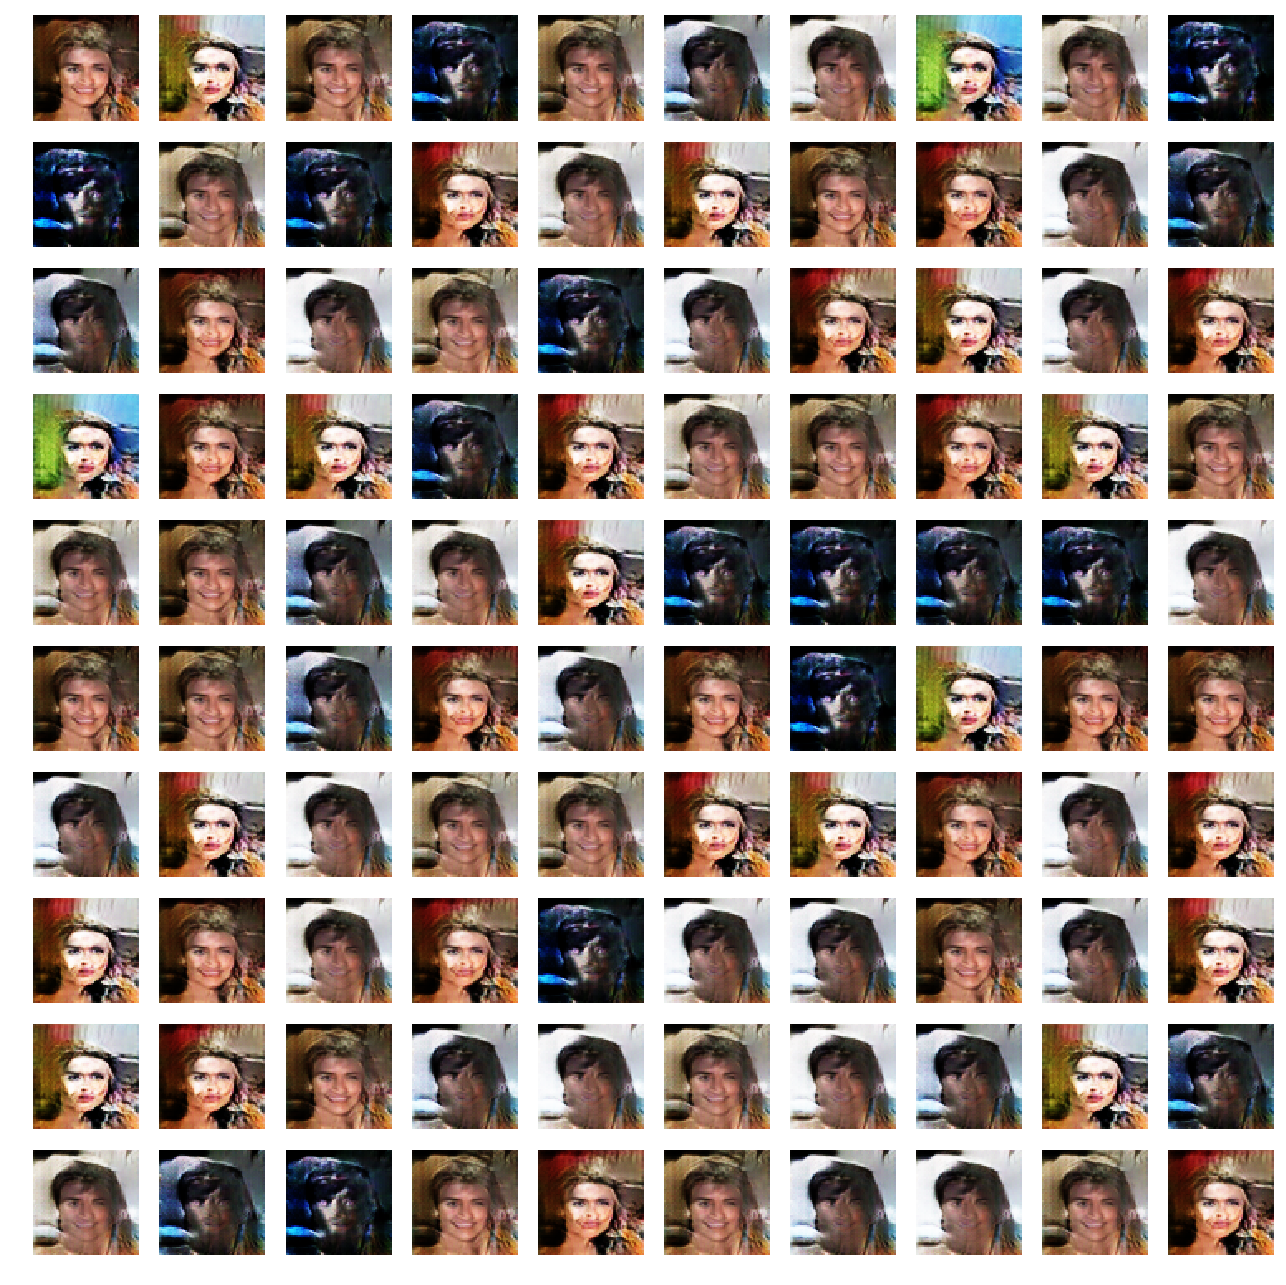

Epoch: 15 [====================>] 202599/202599, loss: d=0.9476, g=6.1569

In [32]:
while epoch < epoch_size:
    d_loss = []
    g_loss = []
    d_loss_category = []
    g_loss_category = []
    
    batch_count = 0    
    status = ('start training')
    sys.stdout.write(status)
    sys.stdout.flush()
    
    shuffle_files = file_names[np.random.permutation(range(len(file_names)))]
    for i in range(count):
        s = i * batch_size
        e = s + batch_size
        
        batch_files = shuffle_files[s:e]
        batch_train, batch_target = batch_from_dataset(batch_files, image_width, image_height), file_tags[s:e]
        batch_train = batch_train.astype(np.float32) * 2 - 1
        batch_count += len(batch_train)
        
        batch_z_var = np.random.normal(-1, 1, size=(len(batch_train), z_var)).astype(np.float32)
        batch_z_category = np.random.randint(0, 2, size=(len(batch_train), z_category))
        
        batch_z = np.concatenate((batch_z_var, batch_z_category), axis=1)
        
        # Discriminator Train
        for _ in range(train_d_count):
            _, loss_d, loss_d_category, loss_d_total = sess.run([Train_D, Loss_D, Loss_D_Category, Loss_D_Total], \
                                 feed_dict={X_Real: batch_train, Y: batch_target, Z: batch_z})
            d_loss += [loss_d]
            d_loss_category += [loss_d_category]
        
        # Generator Train
        for _ in range(train_g_count):
            _, loss_g, loss_g_category, loss_g_total = sess.run([Train_G, Loss_G, Loss_G_Category, Loss_G_Total], \
                                 feed_dict={Z_var: batch_z_var, Z_category: batch_z_category})
            g_loss += [loss_g]
            g_loss_category += [loss_g_category]
                        
        if (i+1) % display_count == 0:
            gen_mnist = sess.run(X_Fake, feed_dict={Z: z_sample})

            display.clear_output(wait=True)
            DisplayHorizontal([ArrayToImage((x * 0.5 + 0.5) * 255) for x in gen_mnist], depth=10, figsize=(16, 16))
            print('Epoch: %d, Count: %d' % (epoch+1, i+1))
            display.display(plt.gcf())
            plt.savefig(sample_figure_path + 'Info_DCGAN_epoch_%d_batch_%d.png' % (epoch+1, i+1))
            plt.close()
            
        if (i+1) % display_count != 0:
            sys.stdout.write('\r')
            sys.stdout.flush()
        status = (("Epoch: %d [%-" + str(display_with + 1) + "s] %d/%d, loss: d=%.4f, g=%.4f") %
          (epoch+1, '=' * int(batch_count / file_size * display_with) + '>', batch_count, file_size, np.mean(loss_d_total), np.mean(loss_g_total)))
        sys.stdout.write(status)
        sys.stdout.flush()
        
    saver.save(sess, model_path + 'Info_DCGAN_CelebA.ckpt')
    
    epoch += 1